this notebook best viewed here: http://nbviewer.jupyter.org

#### Purpose

We ran the same population as individuals (indSeq, via GATK) and as a pool (poolSeq, via VarScan).

Here I read in the intersecting loci among methods, and then look at agreement between indSeq and poolSeq allele frequencies.

I then see what I can do to improve the agreement (eg by excluding megaSNPs, higher depth, etc)


#### Notebook outline
- __Read in the data__ - load data from 001_testdata_explore.ipynb to get SNPs intersecting baseline-filtered GATK and VarScan output

- __Compare allele freqs__ - plot 2D histograms comparing MAF
    - __plotting given allele freqs is messy, let's bin them__ - round AF and MAF to nearest frequency possible for given ploidy, for visualization only
    - __plot allele frequency diffs__ - plot MAF vs rawAFdiff; rawAFdiff = poolAF - indAF

- __Vadidate megaSNPs__ - show that haploid heterozygote SNPs (impossible SNPs for haploid tissue) show patterns of data misaligning to duplicated or diverged paralogs - see 003_testdata_validate_megaSNPs.ipynb

- __See how filtering changes correlation__ - see if further filtering beyond baseline improves agreement between indSeq and poolSeq
    - __re-load data from above__
    - __remove megaSNPS compare to beforehand__ - removing the megaSNPs (impossible heterozygote SNPs from haploid tissue) improves agreement between indSeq and poolSeq AF estimates
    - __compare other filters of poolSeq__
        - __depth__
        - __MAF__
        - __z-score__
        - __H (hetPerc)__
        - __H + z-score__
        - __gatk no missing data + H + z-score__




#### Conclusions

- Overall the agreement between indSeq and poolSeq is quite good even with baseline filtering
- However, with baseline filtering, there are still some disagreement on the minor allele frequency, specifically for those loci that are estimatated to have low MAF in one method having a relatively high MAF in another method. To see why I start filtering to see if I can increase the agreement (correlation) as well as drop these loci that have relatively different allele frequency estimates between the two methods.
- After filtering for hetPerc, z-score, and no missing data, correlation is >0.99 for JP and >0.97 for DF.

# read in data

In [1]:
from pythonimports import *
methodsdir = '/data/home/lindb/methods_paper_analysis'
firstdir = op.join(methodsdir, '001_testdata_explore')
secdir = makedir(op.join(methodsdir, '002_testdata_compare_AFs'))
figdir = makedir(op.join(secdir, 'figures'))

In [2]:
# load in intersecting data created in 001_testdata_explore.ipynb
snps = pklload(op.join(firstdir, 'snps_dict_intersecting_no-noREFloci.pkl'))
# determing MAF
for method,spp in snps.items():
    for sp,df in spp.items():
        print(method, sp, nrow(df))
        locuscol = 'unstitched_locus' if 'unstitched_locus' in df.columns else 'locus'
        df.index = df[locuscol].tolist()
        df['MAF'] = df['AF']
        df.loc[df['MAF']>0.5, 'MAF'] = 1 - df.loc[df['AF']>0.5, 'AF']
df.head()

gatk JP 255706
gatk DF 636279
varscan JP 255706
varscan DF 636279


,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,DF_p52.GT,DF_p52.GQ,DF_p52.SDP,DF_p52.DP,DF_p52.FREQ,DF_p52.PVAL,DF_p52.AD,locus,MAF
>jcf7190000000004-54540,>jcf7190000000004,54540,A,G,0.4643,-10.0,SNP,PASS,28,0,1,0,0,A/G,47,28,28,46.43%,1.981200e-05,13,>jcf7190000000004-54540,0.4643
>jcf7190000000004-54587,>jcf7190000000004,54587,C,T,0.2581,-10.0,SNP,PASS,31,0,1,0,0,C/T,26,31,31,25.81%,2.333200e-03,8,>jcf7190000000004-54587,0.2581
>jcf7190000000004-54589,>jcf7190000000004,54589,C,T,0.8710,-10.0,SNP,PASS,31,0,0,1,0,T/T,129,31,31,87.1%,1.125000e-13,27,>jcf7190000000004-54589,0.1290
>jcf7190000000004-54643,>jcf7190000000004,54643,A,G,0.2286,-10.0,SNP,PASS,35,0,1,0,0,A/G,26,35,35,22.86%,2.493100e-03,8,>jcf7190000000004-54643,0.2286
>jcf7190000000004-54644,>jcf7190000000004,54644,A,G,0.5143,-10.0,SNP,PASS,35,0,1,0,0,A/G,67,35,35,51.43%,1.956200e-07,18,>jcf7190000000004-54644,0.4857


# <center> compare allele frequencies

In [3]:
def get_mafdict(mafs, roundto, count=True):
    """Count number of SNPs in an allele frequency bin."""
    mafs = [round(x, roundto) for x in mafs]
    t = table(mafs)
    mafdict = {}
    for k in t:
        newk = '%.3f' % k  # easier to vis on the x-axis
        if not newk in mafdict:
            mafdict[newk] = t[k]
        else:
            mafdict[newk] += t[k]
    if count is False:
        # if I want proportions
        rets = OrderedDict()
        for newk, count in mafdict.items():
            rets[newk] = count / sum(mafdict.values())
        mafdict = rets
    return mafdict

def subcategorybar(X, vals, width=.9):
    """Set up side-by-side bar plot (histogram) of AF spectra for two datasets."""
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge")   
    plt.xticks(_X, X)

def make_mafdict_fig(pruned_snpdict, all_snpdict, legend, xlab, title=None, saveloc=None):
    """Create side-by-side bar plot (histogram) of AF spectra for two datasets."""
    fig = plt.figure(figsize=(25,5))
    X = ['%.2f' % float(key) for key in sorted(keys(pruned_snpdict))]
    Y = [pruned_snpdict[freq] for freq in sorted(keys(pruned_snpdict))]
    Z = [all_snpdict[freq] for freq in sorted(keys(all_snpdict))]
    subcategorybar(X, [Y,Z])
    plt.legend(legend,fontsize=20)
    plt.ylabel('count',size=20)
    plt.xlabel(xlab,size=20)
    plt.title(title, size=20)
    if saveloc is not None:
        with PdfPages(saveloc) as pdf:
            pdf.savefig(bbox_inches='tight')
        print(ColorText('Saved to: ').bold(), saveloc)
    plt.show()
    pass

def plot_rawAFdiff(gatk, varscan, y='realMAF', x='AF', replace=False, saveloc=None):
    """Plot pAF-iAF vs input column from poolseq."""
    df = varscan[['AF','MAF','realfreq']].copy()
    df[y] = varscan[y]
    df['rawAFdiff'] = df[x] - gatk.loc[df.index, x]
#     return df
    makesweetgraph(df['rawAFdiff'], df[y],
                   xlab=f'rawAFdiff (pool_{x} - ind_{x})',
                   ylab=f'poolSeq {y}' if replace is False else f'{replace} {y}',
                   title=f'{sp} - allele frequency differences', saveloc=saveloc)

In [4]:
from pythonimports import makesweetgraph
??makesweetgraph

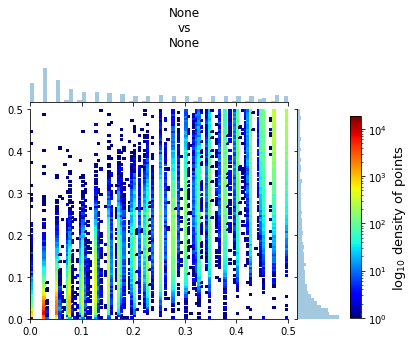

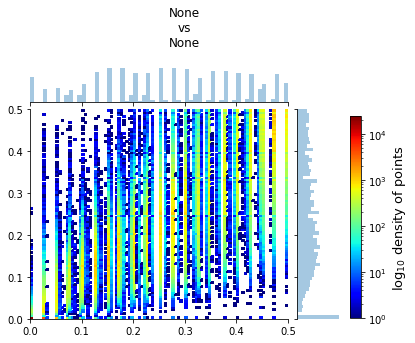

In [5]:
# messy plots comparing AF between methods let's round each AF to nearest possible freq
for sp in ['JP','DF']:
    makesweetgraph(snps['gatk'][sp]['MAF'],
                   snps['varscan'][sp]['MAF'])

## plotting given allele freqs is messy, let's bin them

In [6]:
# put everything into MAF bins
maf_dict = {}
for method,spp in snps.items():
    maf_dict[method] = {}
    for sp,df in spp.items():
        print(method, sp, nrow(df))
        maf_dict[method][sp] = get_mafdict(df['MAF'], roundto=2)
print('\n')

# for allele freqs that do not exist in the other method, create a key with valcount = 0
for sp in ['JP', 'DF']:
    varkeys = keys(maf_dict['varscan'][sp])
    gatkkeys = keys(maf_dict['gatk'][sp])
    allkeys = list(set(varkeys).union(gatkkeys))
    for method in ['varscan', 'gatk']:
        for freq in allkeys:
            if freq not in maf_dict[method][sp]:
                maf_dict[method][sp][freq] = 0
        print(method, sp, len(maf_dict[method][sp]))

gatk JP 255706
gatk DF 636279
varscan JP 255706
varscan DF 636279


varscan JP 51
gatk JP 51
varscan DF 51
gatk DF 51


In [7]:
# create a realfreq column that has only the possible frequency calls (and the associated MAF column)

# first create all possible allele freqs for ploidy=40
realfreqs = [x/40 for x in range(0,41,1)]

# iterate through realfreqs, get cutoffs on either side of realfreq
freqcutoffs = []
for i,freq in enumerate(realfreqs):
    if i==0:
        lastcut = round((freq+realfreqs[i+1])/2, 4)
        freqcutoffs.append([0, lastcut])  # next step rounds any AF > 0 to 0.025
    elif i+1 < len(realfreqs):
        newcut = round((freq+realfreqs[i+1])/2, 4)
        freqcutoffs.append([lastcut, newcut])  # lower and upper thresholds to bin at freq 
        lastcut = newcut
    else:
        freqcutoffs.append([lastcut, 1.0])  # lower and upper thresholds to bin at freq 

# fill in the realfreq column
for method,spp in snps.items():
    for sp,df in spp.items():
        df['realfreq'] = np.nan
        for lowfreq,hifreq in freqcutoffs:
            if lowfreq == 0:
                freq = 0.025  # because there are no loci fixed for ALT (pre-filter)
            elif lowfreq != 0.9875:
                freq = round((lowfreq + hifreq) / 2, 3)
            else:
                freq = 1.0
            df.loc[(df['AF'] > lowfreq) & (df['AF'] <= hifreq), 'realfreq'] = freq

# now create a realMAF column
for method,spp in snps.items():
    for sp,df in spp.items():
        df['realMAF'] = df['realfreq']
        df.loc[df['realMAF']>0.5, 'realMAF'] = round(1 - df.loc[df['realMAF']>0.5, 'realMAF'], 3)
realmafs = sorted(uni([round(x,3) for x in df['realMAF']]))

In [8]:
# make sure all assigned realfreqs are possible (want count of 0 impossible freqs)
for method,spp in snps.items():
    for sp,df in spp.items():
        bad = [x for x in df['realfreq'] if x not in realfreqs]
        print(method, sp, len(bad))

gatk JP 0
gatk DF 0
varscan JP 0
varscan DF 0


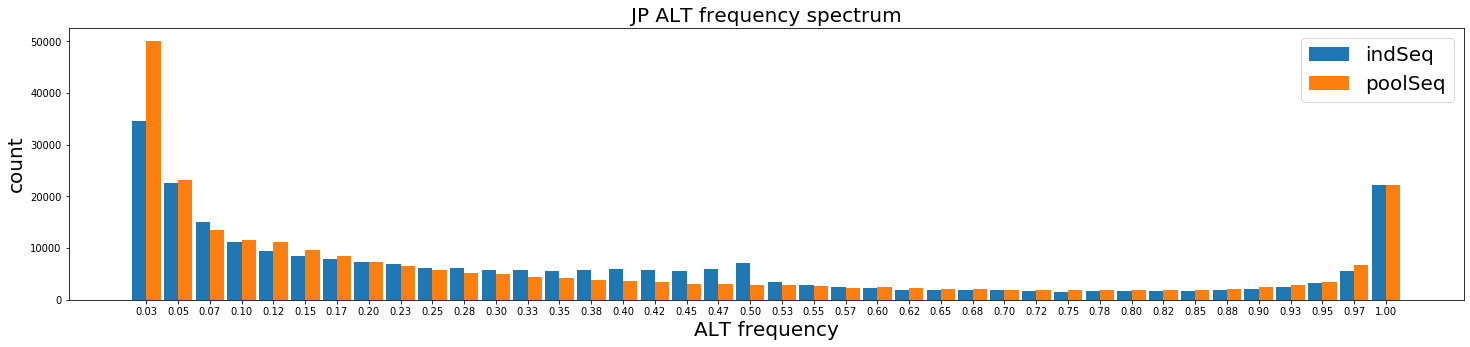

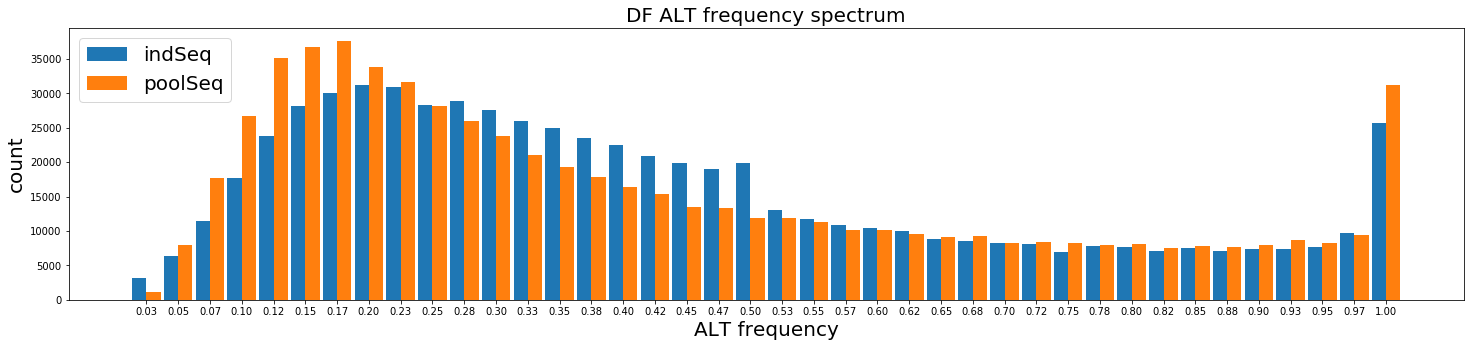

In [9]:
# show species AF spectra, remember loci include some with <25% missing data
for sp in ['JP', 'DF']:
    make_mafdict_fig(get_mafdict(snps['gatk'][sp]['realfreq'], roundto=3),
                     get_mafdict(snps['varscan'][sp]['realfreq'], roundto=3),
                     xlab = 'ALT frequency',
                     legend=['indSeq','poolSeq'], title=f'{sp} ALT frequency spectrum')

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/baseline-filtered_maf-spectrum_JP.pdf


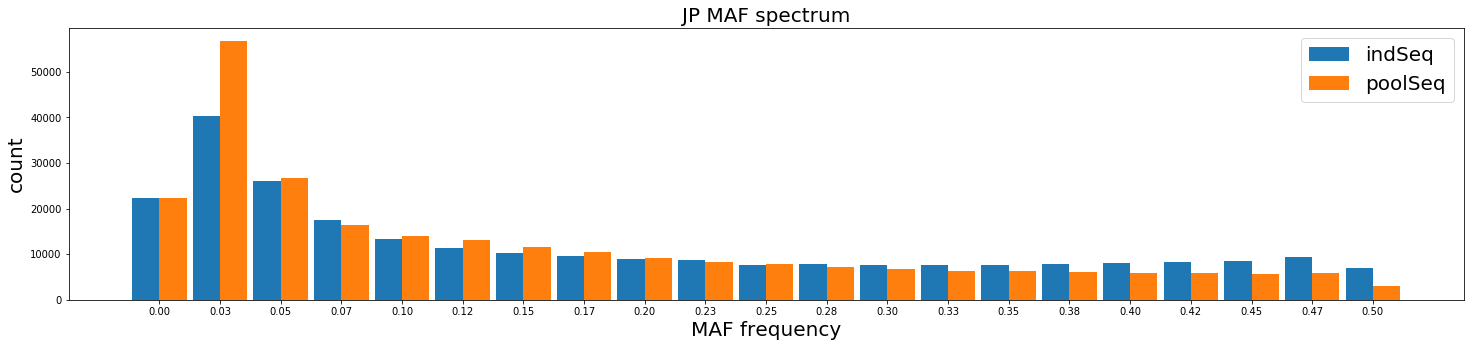

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/baseline-filtered_maf-spectrum_DF.pdf


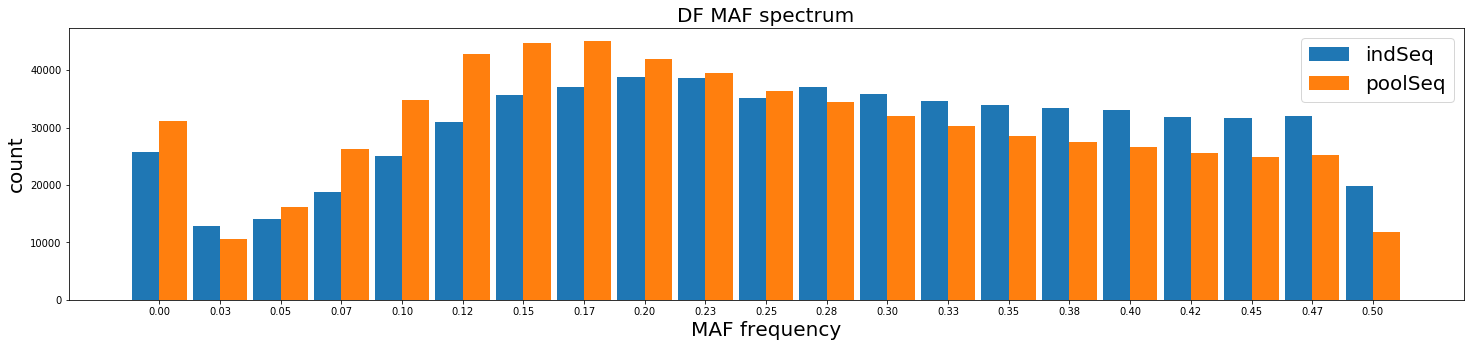

In [10]:
# show species MAF spectra
for sp in ['JP', 'DF']:
    make_mafdict_fig(get_mafdict(snps['gatk'][sp]['realMAF'], roundto=3),
                     get_mafdict(snps['varscan'][sp]['realMAF'], roundto=3),
                     xlab='MAF frequency',
                     legend=['indSeq','poolSeq'], title=f'{sp} MAF spectrum',
                     saveloc=op.join(figdir, f'baseline-filtered_maf-spectrum_{sp}.pdf'))

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/baseline-filtered_congruence_full-AF-spectrum_JP.pdf


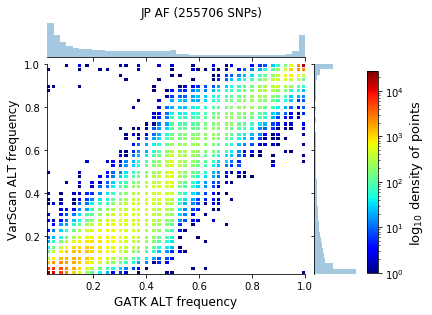

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/baseline-filtered_congruence_full-AF-spectrum_DF.pdf


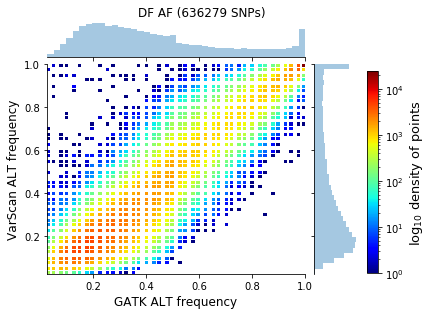

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/baseline-filtered_congruence_MAF-spectrum_JP.pdf


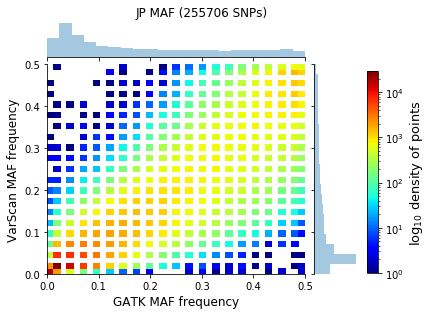

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/baseline-filtered_congruence_MAF-spectrum_DF.pdf


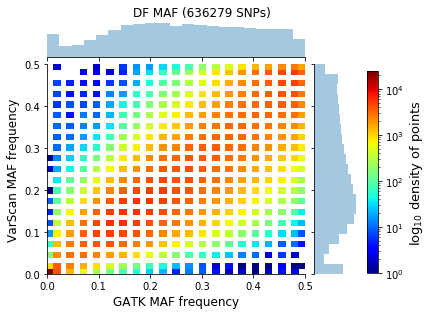

In [11]:
# look at 2D histogram of AF spectra and MAF spectra
for sp in ['JP','DF']:
    makesweetgraph(snps['gatk'][sp]['realfreq'],
                   snps['varscan'][sp]['realfreq'], title=f'{sp} AF (%s SNPs)' % nrow(snps["gatk"][sp]), snsbins=len(realfreqs)-1,
                   xlab='GATK ALT frequency', ylab='VarScan ALT frequency',
                   saveloc=op.join(figdir, f'baseline-filtered_congruence_full-AF-spectrum_{sp}.pdf'))
for sp in ['JP','DF']:
    makesweetgraph(snps['gatk'][sp]['realMAF'],
                   snps['varscan'][sp]['realMAF'], title=f'{sp} MAF (%s SNPs)' % nrow(snps["gatk"][sp]), snsbins=len(realmafs),
                   xlab='GATK MAF frequency', ylab='VarScan MAF frequency', bins=39,
                   saveloc=op.join(figdir, f'baseline-filtered_congruence_MAF-spectrum_{sp}.pdf'))

In [12]:
# compare correlation of AF to correlation of realfreq - it's basically the same
from scipy.stats import pearsonr
for sp in ['JP', 'DF']:
    print(method, sp)
    print('\t', 'AF ', pearsonr(snps['gatk'][sp]['AF'].tolist(), snps['varscan'][sp]['AF']))
    print('\t', 'real AF ', pearsonr(snps['gatk'][sp]['realfreq'].tolist(), snps['varscan'][sp]['realfreq']))

varscan JP
	 AF  (0.9759998798124182, 0.0)
	 real AF  (0.9756174103940884, 0.0)
varscan DF
	 AF  (0.9482729076183054, 0.0)
	 real AF  (0.9479180435445894, 0.0)


In [13]:
# save pkl
pkldump(snps, op.join(secdir, 'snps_dict_intersecting_no-noREFloci_realfreqs.pkl'))

# plot allele frequency diffs

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/baseline-filtered_AFdiff-vs-MAF_JP.pdf


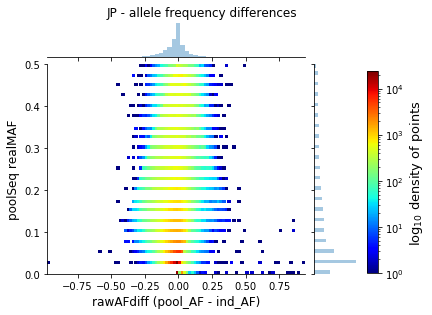

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/baseline-filtered_AFdiff-vs-MAF_DF.pdf


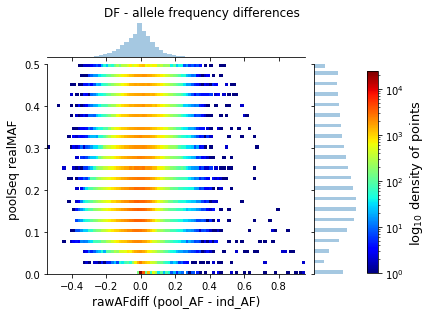

In [14]:
# plot rawAFdiff vs binned MAF
for sp in ['JP','DF']:
    plot_rawAFdiff(snps['gatk'][sp],snps['varscan'][sp],
                   saveloc=op.join(figdir, f'baseline-filtered_AFdiff-vs-MAF_{sp}.pdf'))

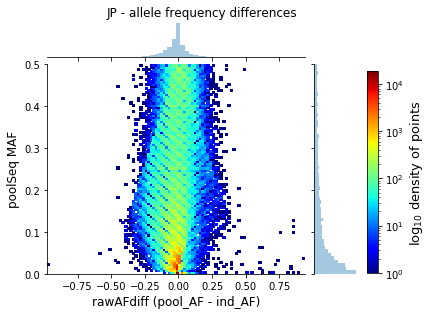

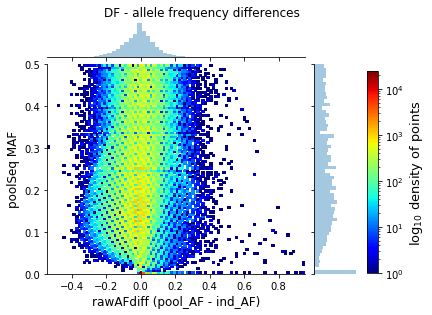

In [15]:
# plot rawAFdiff vs MAF
for sp in ['JP','DF']:
    plot_rawAFdiff(snps['gatk'][sp],snps['varscan'][sp], x='AF', y='MAF')

# <center> Validate megaSNPs </center>
<center> go to 003_testdata_validate_megaSNPs.ipynb and return here </center>

- this section shows that megaSNPs are showing paralog behavior expected from theory (McKinney et al 2017 MolEcolRes)
    - so we should take this into account when analyzing our poolSeq datasets

# <center> See how filtering changes correlation

- first remove sites thought to be due to paralogs/misalignments
    - we used megagametophyte data to identify potential paralogs/misalignments - any heterozygote SNP from haploid data is impossible, and likely due to misalignment (see 003_testdata_validate_megaSNPs.ipynb)
    - look at correlation change after removing these impossible megagametophyte SNPs (megaSNPs) 
    - I'll use megaSNPs from VarScan since this will be our poolSeq method
- then filter for depth, MAF, etc


# re-load data from above

In [16]:
# get megaSNPs, filter for intersection
megafiles = {'JP': '/data/projects/pool_seq/non-pangenome/varscan_mega/JP_RFmg7/snpsANDindels/JP_RFmg7-varscan_all_bedfiles_SNP_paralog_snps_translated.txt',
             'DF': '/data/projects/pool_seq/non-pangenome/varscan_mega/DF_megaSNPs_from_download/DF_mega/snpsANDindels/02_baseline_filtered/DF_mega-varscan_all_bedfiles_SNP_paralog_snps.txt'}
megasnps = {}
for sp,file in megafiles.items():
    megasnps[sp] = pd.read_table(file)
    locuscol = 'unstitched_locus' if 'unstitched_locus' in megasnps[sp].columns else 'locus'
    if locuscol == 'locus':
        loci = [">%s" % locus for locus in megasnps[sp][locuscol].tolist()]
    else:
        loci = megasnps[sp][locuscol].tolist()
    megasnps[sp].index = loci
    print(sp)
    display(megasnps[sp].head())

JP


,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,JP_RFmg7.GT,JP_RFmg7.GQ,JP_RFmg7.SDP,JP_RFmg7.DP,JP_RFmg7.FREQ,JP_RFmg7.PVAL,locus,unstitched_chrom,unstitched_pos,unstitched_locus
>super27-173057,Scaffold_2,173057,C,T,0.7778,-10.0,SNP,PASS,9,0,1,0,0,C/T,29,9,9,77.78%,0.001131,Scaffold_2-173057,>super27,173057,>super27-173057
>super27-174201,Scaffold_2,174201,T,C,0.7000,-10.0,SNP,PASS,10,0,1,0,0,T/C,28,10,10,70%,0.001548,Scaffold_2-174201,>super27,174201,>super27-174201
>super27-174218,Scaffold_2,174218,C,T,0.6667,-10.0,SNP,PASS,9,0,1,0,0,C/T,23,9,9,66.67%,0.004525,Scaffold_2-174218,>super27,174218,>super27-174218
>super27-574293,Scaffold_2,574293,C,T,0.4615,-10.0,SNP,PASS,13,0,1,0,0,C/T,21,13,13,46.15%,0.007453,Scaffold_2-574293,>super27,574293,>super27-574293
>super27-574357,Scaffold_2,574357,A,C,0.5455,-10.0,SNP,PASS,11,0,1,0,0,A/C,22,11,11,54.55%,0.006192,Scaffold_2-574357,>super27,574357,>super27-574357


DF


,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,DF_mega.GT,DF_mega.GQ,DF_mega.SDP,DF_mega.DP,DF_mega.FREQ,DF_mega.PVAL,DF_mega.AD,DF_mega.RD,locus
>jcf7190000000008-199707,jcf7190000000008,199707,T,A,0.5000,-10.0,SNP,PASS,12,0,1,0,0,T/A,21,12,12,50%,0.006865,6,6,jcf7190000000008-199707
>jcf7190000000008-199711,jcf7190000000008,199711,G,A,0.5000,-10.0,SNP,PASS,12,0,1,0,0,G/A,21,12,12,50%,0.006865,6,6,jcf7190000000008-199711
>jcf7190000000008-199767,jcf7190000000008,199767,T,G,0.5000,-10.0,SNP,PASS,12,0,1,0,0,T/G,21,12,12,50%,0.006865,6,6,jcf7190000000008-199767
>jcf7190000000008-199784,jcf7190000000008,199784,A,T,0.6667,-10.0,SNP,PASS,9,0,1,0,0,A/T,23,9,9,66.67%,0.004525,6,3,jcf7190000000008-199784
>jcf7190000000008-207192,jcf7190000000008,207192,A,C,0.7500,-10.0,SNP,PASS,8,0,1,0,0,A/C,24,8,8,75%,0.003497,6,2,jcf7190000000008-207192


In [17]:
# look at intersection with data
for sp in ['JP', 'DF']:
    print(sp, len(set(snps['varscan'][sp].index).intersection(megasnps[sp].index.tolist())))

JP 7006
DF 248


In [18]:
from scipy.stats import pearsonr

# remove megaSNPs compare to beforehand

In [19]:
# look at how correlation changes - it increases
newsnps = {'gatk':{}, 'varscan':{}}
for sp,col in zip(['JP','DF'], ['JP_p101.FREQ','DF_p52.FREQ']):
    gatk = snps['gatk'][sp].copy()
    varscan = snps['varscan'][sp].copy()
    print(sp)
    print(ColorText('\tBefore removing megaSNPs').bold())
    print('\tshape = ', gatk.shape, varscan.shape)
    p1 = pearsonr(gatk['AF'], varscan[col].str.replace("%","").astype(float)/100)
    print('\t', p1)
    print(ColorText('\tAfter ...').bold())
    gatk_loci = set(gatk.index.tolist()) - set(megasnps[sp].index.tolist())
    varscan_loci = set(varscan.index.tolist()) - set(megasnps[sp].index.tolist())
    inter = list(set(gatk_loci).intersection(varscan_loci))
    gatk = gatk[gatk.index.isin(inter)].copy()
    varscan = varscan[varscan.index.isin(inter)].copy()
    print('\tshape = ', gatk.shape, varscan.shape)
    p2 = pearsonr(gatk['AF'], varscan[col].str.replace("%","").astype(float)/100)
    print('\t', p2)
    if p2[0] >= p1[0]:
        print(ColorText('\n\tCorrelation increased!!!\n').bold().green())
    else:
        print(ColorText('\n\tCorrelation decreased!!!\n').bold().fail())

    # put in new dict
    newsnps['gatk'][sp] = gatk.copy()
    newsnps['varscan'][sp] = varscan.copy()

JP
	Before removing megaSNPs
	shape =  (255706, 120) (255706, 24)
	 (0.9759998798124182, 0.0)
	After ...
	shape =  (248700, 120) (248700, 24)
	 (0.9775553255366799, 0.0)

	Correlation increased!!!

DF
	Before removing megaSNPs
	shape =  (636279, 120) (636279, 24)
	 (0.9482729076183054, 0.0)
	After ...
	shape =  (636031, 120) (636031, 24)
	 (0.9483077342888863, 0.0)

	Correlation increased!!!



In [20]:
def compare_sweetgraphs(before, after, doingwhat='', ret_after=False, saveloc=None):
    """Create two sweetgraphs for comparison, one before filtering and one after filtering."""
    for sp in ['JP', 'DF']:
        makesweetgraph(before['gatk'][sp]['realMAF'],
                       before['varscan'][sp]['realMAF'],
                       title=f'{sp} MAF ({nrow(before["gatk"][sp])} SNPs)\nAfter removing megaSNPs, before {doingwhat}',
                       snsbins=luni(before['gatk'][sp]['realMAF']), bins=39,
                       xlab='GATK MAF frequency', ylab='VarScan MAF frequency', xlim=(0,0.5), ylim=(0,0.5),
                       vlim=(1,32000))
        makesweetgraph(after['gatk'][sp]['realMAF'],
                       after['varscan'][sp]['realMAF'],
                       title=f'{sp} MAF ({nrow(after["gatk"][sp])} SNPs)\nAfter removing megaSNPs, after {doingwhat}',
                       snsbins=luni(after['gatk'][sp]['realMAF']), bins=39,
                       xlab='GATK MAF frequency', ylab='VarScan MAF frequency', xlim=(0,0.5), ylim=(0,0.5),
                       vlim=(1,32000),
                       saveloc=saveloc.replace('.pdf', f'_{sp}.pdf') if saveloc is not None else None)
    if ret_after is True:
        return after

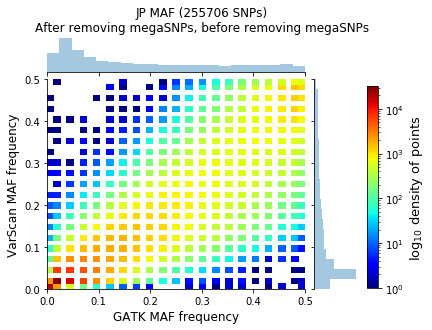

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/baseline-filtered_congruence_MAF-spectrum_after-removing-megaSNPs_JP.pdf


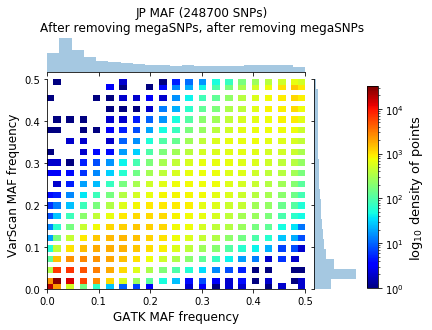

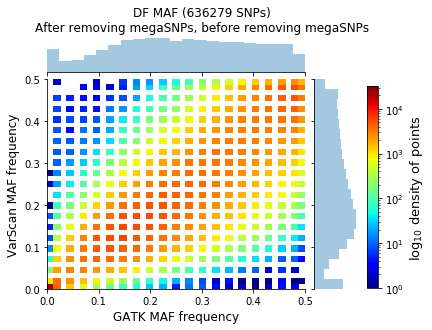

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/baseline-filtered_congruence_MAF-spectrum_after-removing-megaSNPs_DF.pdf


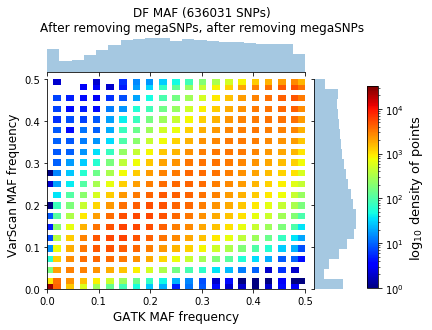

In [21]:
# visually compare before/after removing megaSNPs
# this before fig should be the same as f'baseline-filtered_congruence_MAF-spectrum_{sp}.pdf' above
compare_sweetgraphs(before=snps,
                    after=newsnps,
                    doingwhat='removing megaSNPs',
                    saveloc=op.join(figdir, 'baseline-filtered_congruence_MAF-spectrum_after-removing-megaSNPs.pdf'))

# compare other filters of poolSeq

In [22]:
def print_corr(gatk1, gatk2, varscan1, varscan2, colheader):
    """Calculate Pearson's r for before/after filtering and report if it increased/decreased."""
    # get correlation
    p1 = pearsonr(gatk1['AF'], varscan1[f'{colheader}.FREQ'].str.replace("%","").astype(float)/100)
    p2 = pearsonr(gatk2['AF'], varscan2[f'{colheader}.FREQ'].str.replace("%","").astype(float)/100)
    if p2[0] > p1[0]:
        print(ColorText('Correlation increased!!!').bold().green())
    else:
        print(ColorText('Correlation decreased :(').bold().fail())
    print(round(p1[0], 5), round(p2[0], 5), '\n')

def filter_snps(snpdict, col=None, byval=None, greaterthan=True, filtergatk=False, byval2=None):
    """Filter poolSeq data, get gatk intersection."""
    mydict = {'gatk':{}, 'varscan':{}}
    for sp,colheader in zip(['JP','DF'], ['JP_p101','DF_p52']):
        if '.' in col:
            mycol = f'{colheader}{col}'
        else:
            mycol = col
        # filter varscan
        varscan = snpdict['varscan'][sp].copy()
        print(sp, 'starting = ', nrow(varscan))
        if greaterthan is True and byval2 is None:
            varscan = varscan[varscan[mycol] >= byval].copy()
        elif greaterthan is False and byval2 is None:
            varscan = varscan[varscan[mycol] <= byval].copy()
        elif greaterthan is True and byval2 is not None:
            print('special filter')
            varscan = varscan[(varscan[mycol] <= byval) | (varscan[mycol] >= byval2)]
        else:
            raise AssertionError
        print(sp, 'ending = ', nrow(varscan))
        # filter gatk for intersection
        gatk = snpdict['gatk'][sp].loc[varscan.index,:].copy()
        # filter gatk if prompted, get intersection
        if filtergatk is True and greaterthan is True:
            gatk = gatk[gatk[mycol] >= byval].copy()
            loci = list(set(gatk.index).intersection(varscan.index))
            gatk = gatk[gatk.index.isin(loci)].copy()
            varscan = varscan[varscan.index.isin(loci)].copy()
        elif filtergatk is True and greaterthan is False:
            gatk = gatk[gatk[mycol] <= byval].copy()
            loci = list(set(gatk.index).intersection(varscan.index))
            gatk = gatk[gatk.index.isin(loci)].copy()
            varscan = varscan[varscan.index.isin(loci)].copy()
        mydict['varscan'][sp] = varscan
        mydict['gatk'][sp] = gatk
        
        # get correlation
        print_corr(snpdict['gatk'][sp], gatk, snpdict['varscan'][sp], varscan, colheader)
    return mydict

### lower depth

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/megaSNP-filtered_AFdiff-vs-depth_JP.pdf


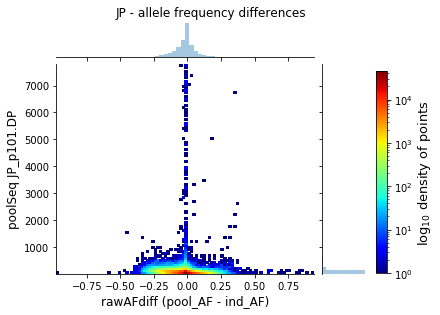

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/megaSNP-filtered_AFdiff-vs-depth_DF.pdf


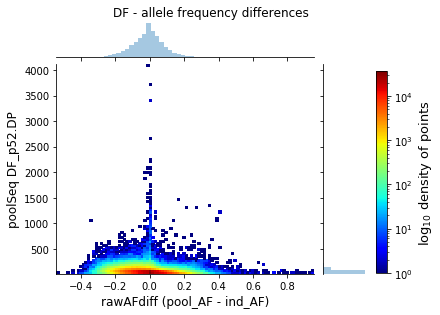

In [23]:
# there is a good spread of rawAFdiff at low depth, next see if filtering does anything for correlation
for sp,ycol in zip(['JP','DF'], ['JP_p101.DP','DF_p52.DP']):
    plot_rawAFdiff(newsnps['gatk'][sp], newsnps['varscan'][sp], y=ycol,
                   saveloc=op.join(figdir, f'megaSNP-filtered_AFdiff-vs-depth_{sp}.pdf'))

JP starting =  248700
JP ending =  248199
Correlation increased!!!
0.97756 0.97756 

DF starting =  636031
DF ending =  577446
Correlation increased!!!
0.94831 0.94997 



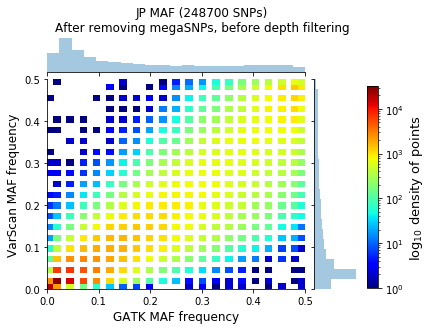

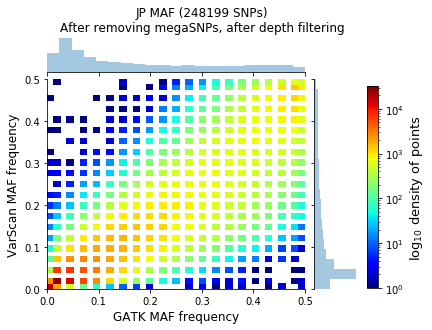

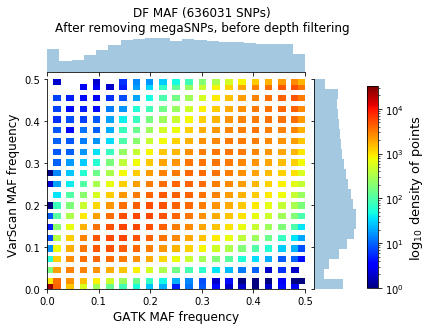

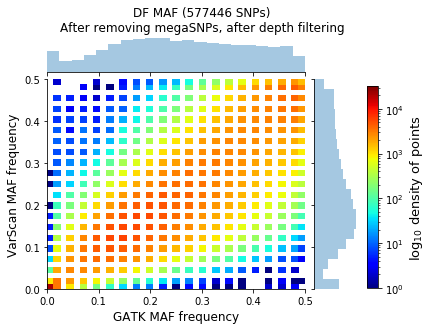

In [24]:
# compare before/after fitlering for depth >= 30 - correlation increases, visually hard to tell from figs ...
# ... so I'm not going to save a fig
compare_sweetgraphs(before=newsnps,
                    after=filter_snps(newsnps, col='.DP', byval=30),
                    doingwhat='depth filtering')

### MAF

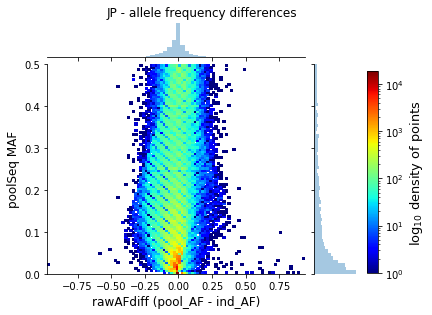

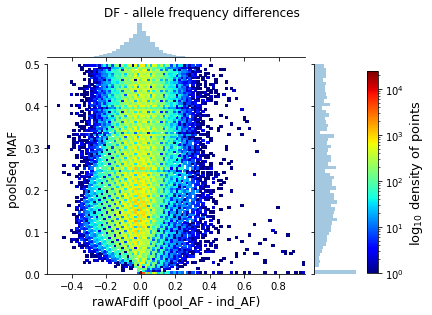

In [25]:
# doesn't look like low MAF filtering will help, but check and see below
for sp in ['JP','DF']:
    plot_rawAFdiff(newsnps['gatk'][sp], newsnps['varscan'][sp], y='MAF')

JP starting =  248700
JP ending =  155257
Correlation decreased :(
0.97756 0.93732 

DF starting =  636031
DF ending =  587704
Correlation decreased :(
0.94831 0.92296 



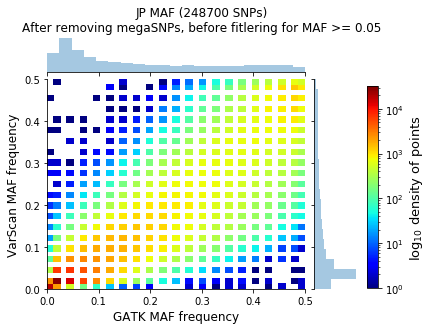

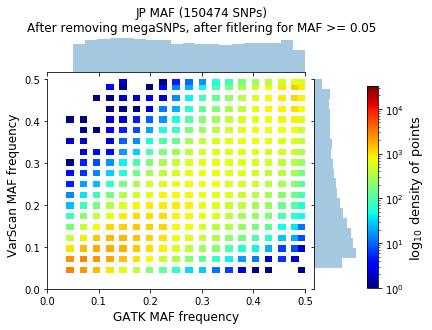

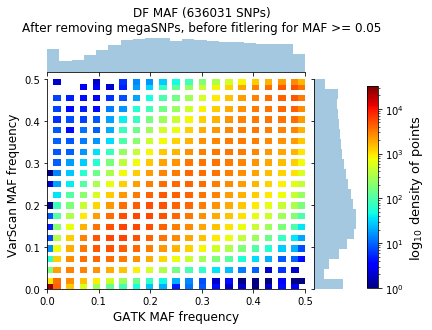

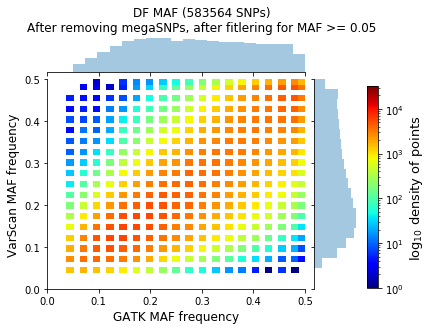

In [26]:
# compare before/after fitlering for MAF >= 0.05 - as expected from rawAFdiff figs, correlation decreased
compare_sweetgraphs(before=newsnps,
                    after=filter_snps(newsnps, col='MAF', byval=0.05, filtergatk=True),
                    doingwhat='fitlering for MAF >= 0.05')

JP starting =  248700
JP ending =  155257
Correlation decreased :(
0.97756 0.93732 

DF starting =  636031
DF ending =  587704
Correlation decreased :(
0.94831 0.92296 

JP starting =  150474
JP ending =  150140
Correlation increased!!!
0.93732 0.93736 

DF starting =  583564
DF ending =  531535
Correlation increased!!!
0.92296 0.92494 



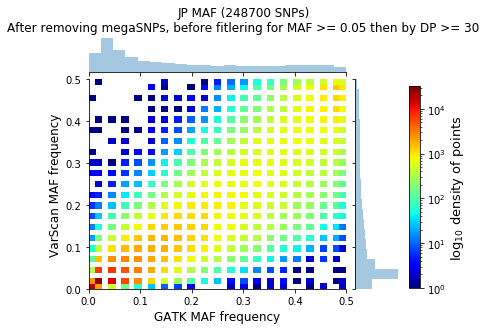

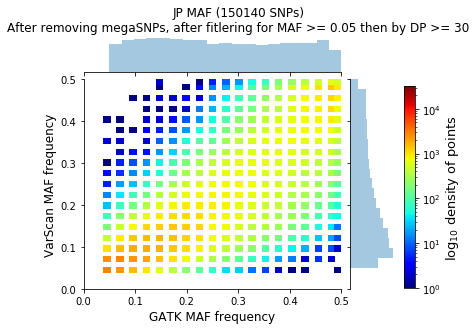

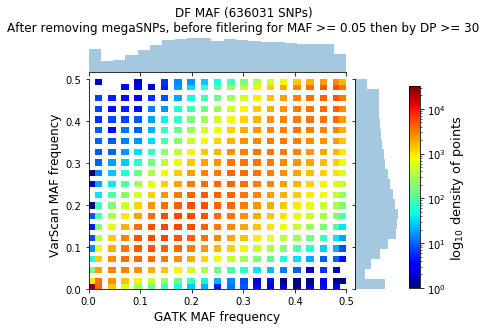

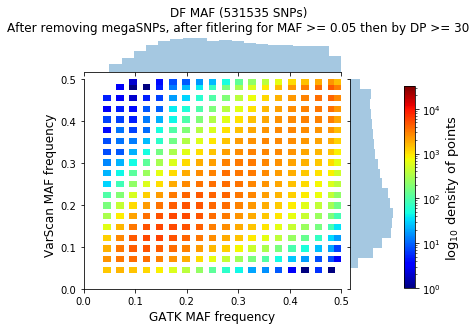

In [27]:
# fitler for MAF then by depth >= 30 - final correlation lower than just depth alone
compare_sweetgraphs(before=newsnps,
                    after=filter_snps(filter_snps(newsnps, col='MAF', byval=0.05, filtergatk=True),
                                      col='.DP', byval=30),
                    doingwhat='fitlering for MAF >= 0.05 then by DP >= 30')

### z-score

While the correlation decreased (and not by much), some of the major-discrepancy SNPs drop out (those SNPs with low MAF by one method but high MAF by another method - see top L and bottom R corners in figures below)

In [28]:
# from 003_testdata_validate_gatk_megaSNPs.ipynb
def get_z_scores(df):
    """Use read ratio statistics to calculate z-scores."""
    from scipy.stats import binom
    # modified from https://datadryad.org/resource/doi:10.5061/dryad.cm08m : HDplot_python.py
    #SUM READ COUNTS PER LOCUS
    df['HET-TOTAL_AD'] = df['HET_REF_AD'] + df['HET_ALT_AD']
    #CALCULATE HETEROZYGOSITY perc
    df['hetPerc'] = [df.loc[row,'num_hets']/df.loc[row,'num_samples'] for row in df.index]
    #CALCULATE EXPECTED STANDARD DEVIATION BASED ON BINOMIAL DISTRIBUTION
    df['std'] = binom(n = df['HET-TOTAL_AD'], p = .5).std()
    #CALCULATE Z-SCORE BASED ON STANDARD DEVIATION
    df['z'] = (df['HET_REF_AD'] - (df['HET-TOTAL_AD']/2))/ df['std']
    # (mine) add in MAF so I don't have to use a dict
    df['MAF'] = [1-round(float(af),3) if round(float(af),3) > 0.5 else round(float(af),3) for af in df['AF']]
    return df

In [29]:
# add in the z-score information to the newsnps dict
for sp in ['JP', 'DF']:
    print(sp)
    adfile = f'/data/home/lindb/methods_paper_analysis/003_testdata_validate_megaSNPs/full-AD_depths-{sp}.txt'
    df = get_z_scores(pd.read_table(adfile))
    df.index = df['locus_ID'].tolist()
    interloci = list(set(df.index).intersection(newsnps['varscan'][sp].index.tolist()))
    for col in nb(list(df.columns)[4:-1]):
        newsnps['varscan'][sp].loc[interloci, col] = df.loc[interloci, col]
    newsnps['varscan'][sp]['abs(z)'] = abs(newsnps['varscan'][sp]['z'])

JP


100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


DF


100%|██████████| 13/13 [00:38<00:00,  3.00s/it]


Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/megaSNP-filtered_AFdiff-vs-abs_z_score_JP.pdf


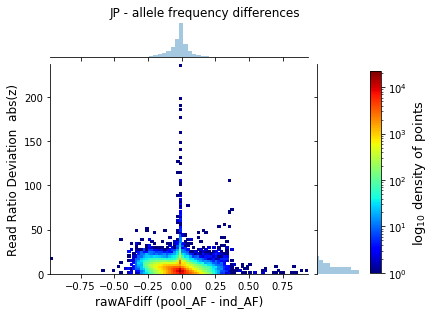

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/megaSNP-filtered_AFdiff-vs-abs_z_score_DF.pdf


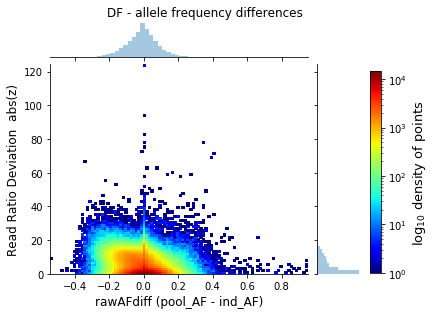

In [30]:
# it loos like ther are some high Z that will skew rawAFdiff, look more closely at raw z next
for sp in ['JP','DF']:
    loci = newsnps['varscan'][sp][newsnps['varscan'][sp]['abs(z)'] == newsnps['varscan'][sp]['abs(z)']].index.tolist()
    plot_rawAFdiff(newsnps['gatk'][sp].loc[loci,:], newsnps['varscan'][sp].loc[loci,:],
                   y='abs(z)', replace='Read Ratio Deviation ',
                   saveloc=op.join(figdir, f'megaSNP-filtered_AFdiff-vs-abs_z_score_{sp}.pdf'))

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/megaSNP-filtered_AFdiff-vs-z_score_JP.pdf


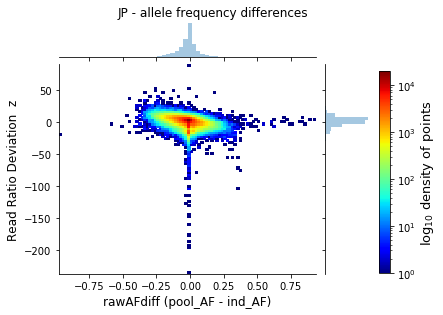

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/megaSNP-filtered_AFdiff-vs-z_score_DF.pdf


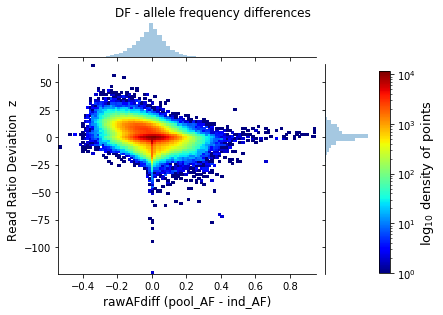

In [31]:
# raw z better shows how high z will result in larger rawAFdiff skews
for sp in ['JP','DF']:
    loci = newsnps['varscan'][sp][newsnps['varscan'][sp]['z'] == newsnps['varscan'][sp]['z']].index.tolist()
    plot_rawAFdiff(newsnps['gatk'][sp].loc[loci,:], newsnps['varscan'][sp].loc[loci,:], y='z',
                   replace='Read Ratio Deviation ',
                   saveloc=op.join(figdir, f'megaSNP-filtered_AFdiff-vs-z_score_{sp}.pdf'))

In [32]:
# baseline-filtered_congruence_MAF-spectrum_

JP starting =  248700
JP ending =  213421
Correlation decreased :(
0.97756 0.97594 

DF starting =  636031
DF ending =  523927
Correlation decreased :(
0.94831 0.9449 



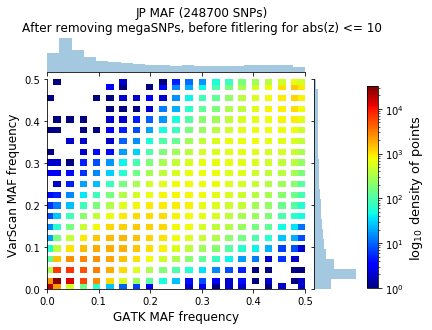

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/megaSNP-filtered_congruence_MAF-spectrum_after-removing-abs-z-score_JP.pdf


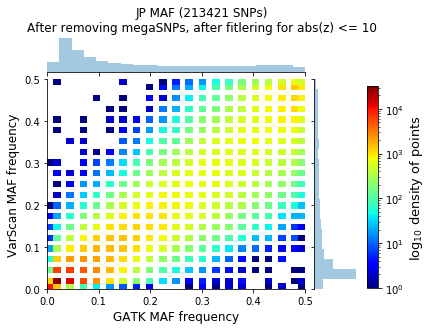

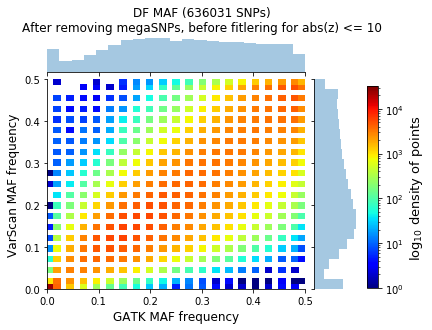

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/megaSNP-filtered_congruence_MAF-spectrum_after-removing-abs-z-score_DF.pdf


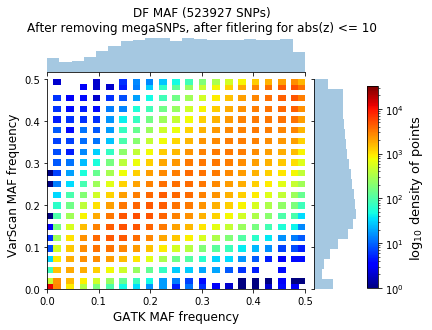

In [33]:
# compare before/after fitlering for abs(z) <= 10 - correlation goes down but not by much, corners drop out
compare_sweetgraphs(before=newsnps,
                    after=filter_snps(newsnps, col='abs(z)', greaterthan=False, byval=10),
                    doingwhat='fitlering for abs(z) <= 10',
                    saveloc=op.join(figdir, 'megaSNP-filtered_congruence_MAF-spectrum_after-removing-abs-z-score.pdf'))

JP starting =  248700
special filter
JP ending =  246626
Correlation decreased :(
0.97756 0.9769 

DF starting =  636031
special filter
DF ending =  629894
Correlation decreased :(
0.94831 0.94617 



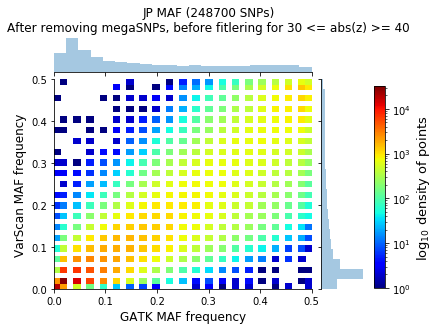

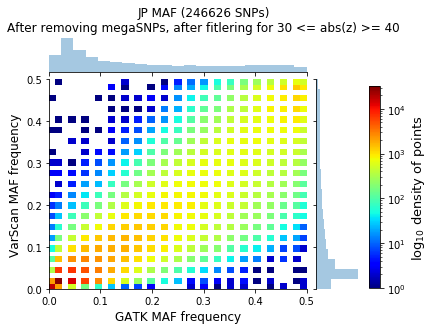

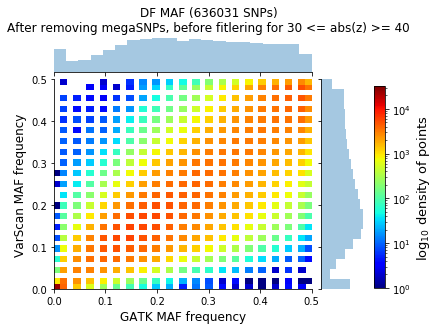

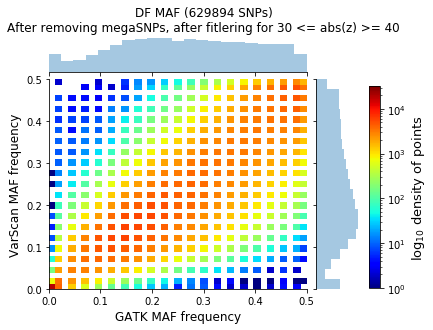

In [34]:
# compare before/after fitlering for 30 <= abs(z) >= 40 - correlation goes down but not by much
# 30 <= abs(z) >= 40 becase @ >50, rawAFdiff is 0
compare_sweetgraphs(before=newsnps,
                    after=filter_snps(newsnps, col='abs(z)', greaterthan=True, byval=30, byval2=40),
                    doingwhat='fitlering for 30 <= abs(z) >= 40')

#### H (hetPerc)

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/megaSNP-filtered_AFdiff-vs-hetPerc_JP.pdf


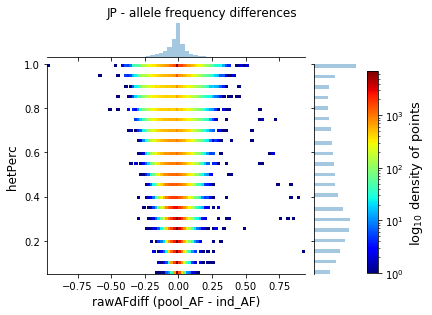

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/megaSNP-filtered_AFdiff-vs-hetPerc_DF.pdf


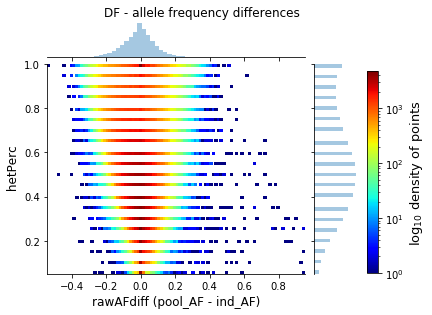

In [35]:
# with larger hetPerc, the greater the spread of rawAFdiff
for sp in ['JP','DF']:
    loci = newsnps['varscan'][sp][newsnps['varscan'][sp]['hetPerc'] == newsnps['varscan'][sp]['hetPerc']].index.tolist()
    plot_rawAFdiff(newsnps['gatk'][sp].loc[loci,:], newsnps['varscan'][sp].loc[loci,:], y='hetPerc', replace='',
                   saveloc=op.join(figdir, f'megaSNP-filtered_AFdiff-vs-hetPerc_{sp}.pdf'))

JP starting =  248700
JP ending =  162405
Correlation increased!!!
0.97756 0.98868 

DF starting =  636031
DF ending =  385656
Correlation increased!!!
0.94831 0.96881 



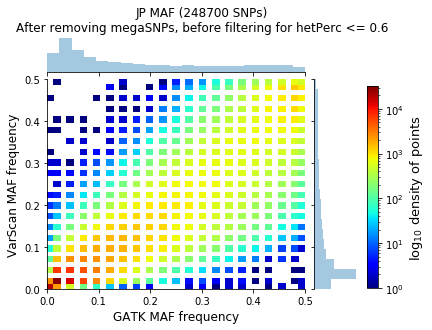

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/megaSNP-filtered_congruence_MAF-spectrum_after-removing-hetPerc-lt-p6_JP.pdf


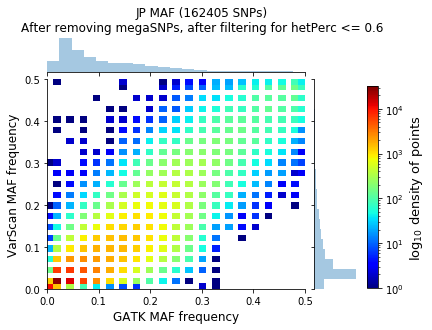

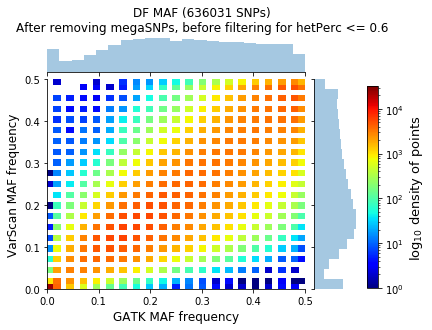

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/megaSNP-filtered_congruence_MAF-spectrum_after-removing-hetPerc-lt-p6_DF.pdf


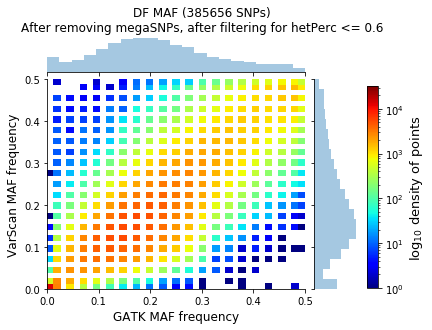

In [36]:
# compare before/after fitlering for hetPerc <= 0.6 - a lot of the corners drop out
compare_sweetgraphs(before=newsnps,
                    after=filter_snps(newsnps, col='hetPerc', greaterthan=False, byval=0.6),
                    doingwhat='filtering for hetPerc <= 0.6',
                    saveloc=op.join(figdir, 
                                    'megaSNP-filtered_congruence_MAF-spectrum_after-removing-hetPerc-lt-p6.pdf'))

#### H + z-score

JP starting =  248700
JP ending =  213421
Correlation decreased :(
0.97756 0.97594 

DF starting =  636031
DF ending =  523927
Correlation decreased :(
0.94831 0.9449 

JP starting =  213421
JP ending =  153046
Correlation increased!!!
0.97594 0.9897 

DF starting =  523927
DF ending =  339797
Correlation increased!!!
0.9449 0.97022 



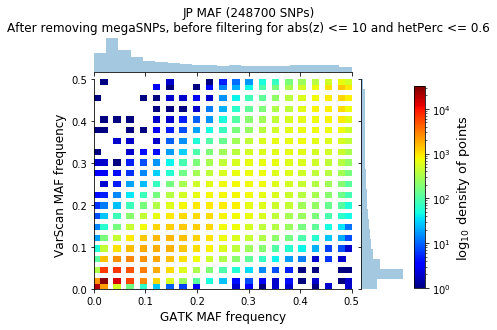

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/megaSNP-filtered_congruence_MAF-spectrum_after-filtering-z-and-hetPerc_JP.pdf


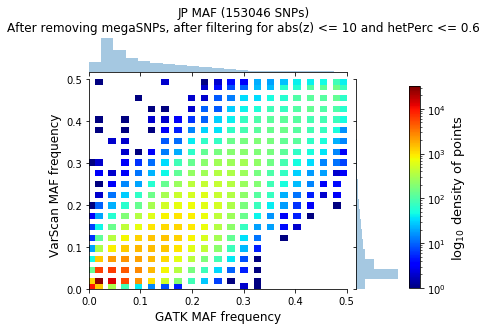

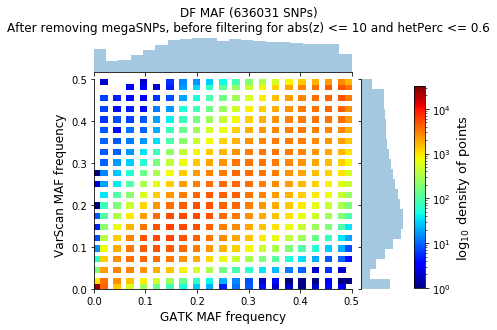

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/megaSNP-filtered_congruence_MAF-spectrum_after-filtering-z-and-hetPerc_DF.pdf


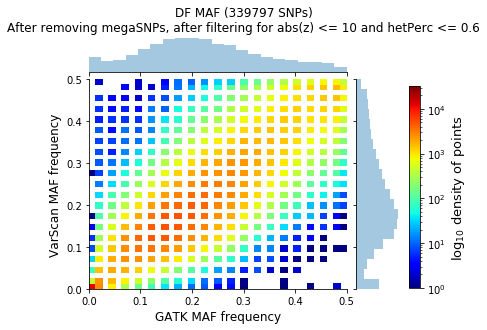

In [37]:
# correlation is higher after filtering for hetPerc AND z-score than with hetPerc alone
compare_sweetgraphs(before=newsnps,
                    after=filter_snps(filter_snps(newsnps, col='abs(z)', greaterthan=False, byval=10),
                                      col='hetPerc', greaterthan=False, byval=0.6),
                    doingwhat='filtering for abs(z) <= 10 and hetPerc <= 0.6',
                    saveloc=op.join(figdir, 'megaSNP-filtered_congruence_MAF-spectrum_after-filtering-z-and-hetPerc.pdf'))

### filter gatk for less missing data + hetPerc + z-score

Our current missing data threshold is 25%. To get the best idea of how our poolSeq SNPs are doing, let's use little to no missing data in our indSeq data.

In [38]:
lview,dview = get_client()

56 56


#### look at filtering alone

In [39]:
def watch_async(jobs:list, phase=None, sleep=5, refresh=True) -> None:
    """Wait until jobs are done executing, get updates"""
    print(len(jobs))
    count = 0
    while count != len(jobs):
        time.sleep(sleep)
        count = 0
        for j in jobs:
            if j.ready():
                count += 1
        if refresh is True:
            if phase is not None:
                update([phase, count, len(jobs)])
            else:
                update([count, len(jobs)])

In [40]:
def count_missing(df, thresh):
    """Count number of missing genotypes and keep only those below threshold missing data."""
    import pandas
    keep = []
    for locus in df.index:
        sums = sum(1 if gt!=gt or gt=='./.' else 0 for gt in df.loc[locus, :])
        if sums < thresh:
            keep.append(locus)
    return keep

def filter_missing_data(snpdict, thresh, ret=False):
    """Filter missing data in parallel using ipcluster engines."""
    newdict = {'gatk':{}, 'varscan':{}}
    for sp in ['JP', 'DF']:
        jobs = []
        gtcols = [col for col in snpdict['gatk'][sp] if '.GT' in col]
        gatk = snpdict['gatk'][sp][gtcols]
        tosend = []
        for i,locus in enumerate(nb(gatk.index)):
            tosend.append(locus)
            if len(tosend) == math.ceil(nrow(gatk)/56) or (i+1) == nrow(gatk):
                jobs.append(lview.apply_async(count_missing, *(gatk.loc[tosend, :], thresh)))
                tosend = []
        watch_async(jobs, refresh=False)
        loci = []
        for j in jobs:
            loci.extend(j.r)
#         return loci
        newdict['gatk'][sp] = snpdict['gatk'][sp].loc[loci, :].copy()
        newdict['varscan'][sp] = snpdict['varscan'][sp].loc[loci, :].copy()
    for sp,colheader in zip(['JP','DF'], ['JP_p101','DF_p52']):
        print(f'{sp} starting = ', nrow(snpdict['gatk'][sp]) )
        print(f'{sp} ending = ', nrow(snpdict['gatk'][sp]))
        print_corr(snpdict['gatk'][sp], newdict['gatk'][sp],
                   snpdict['varscan'][sp], newdict['varscan'][sp],
                   colheader)
    return newdict

100%|██████████| 248700/248700 [00:01<00:00, 200478.17it/s]


56


100%|██████████| 636031/636031 [00:02<00:00, 231353.06it/s]


56
JP starting =  248700
JP ending =  248700
Correlation increased!!!
0.97756 0.98508 

DF starting =  636031
DF ending =  636031
Correlation increased!!!
0.94831 0.96558 



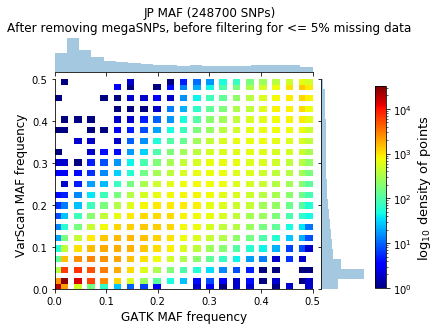

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/megaSNP-filtered_congruence_MAF-spectrum_after-removing-lt-5perc-missing_JP.pdf


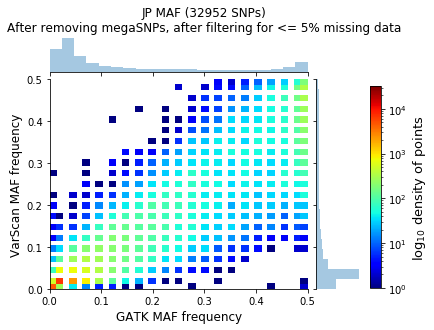

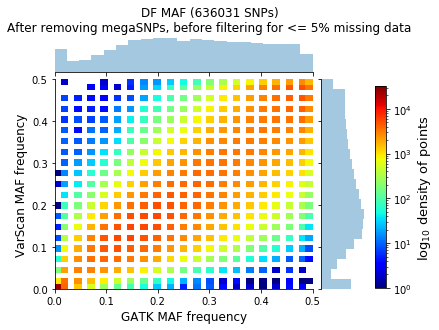

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/megaSNP-filtered_congruence_MAF-spectrum_after-removing-lt-5perc-missing_DF.pdf


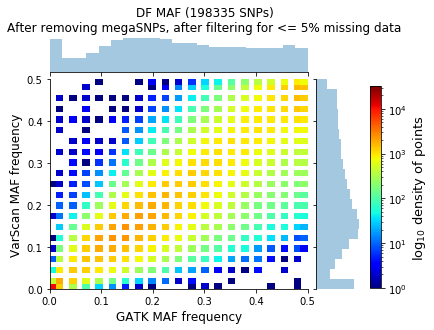

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/megaSNP-filtered_5perc-missing-filtered_maf-spectrum_JP.pdf


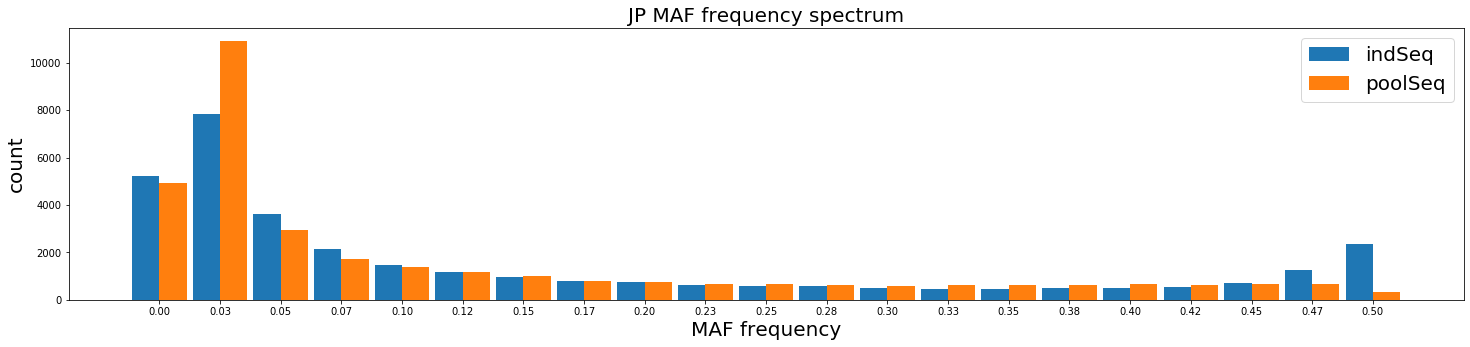

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/megaSNP-filtered_5perc-missing-filtered_maf-spectrum_DF.pdf


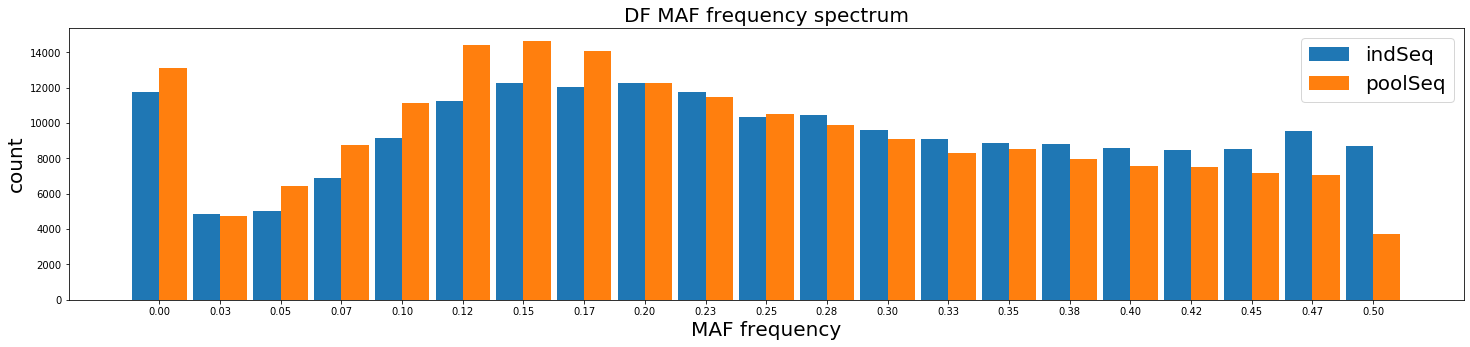

In [41]:
# filter for < 5% missing data (1/20 = 0.05)
after = filter_missing_data(newsnps, 1, ret=True)
compare_sweetgraphs(before=newsnps,
                    after=after,
                    doingwhat='filtering for <= 5% missing data',
                    saveloc=op.join(figdir,
                                    'megaSNP-filtered_congruence_MAF-spectrum_after-removing-lt-5perc-missing.pdf'))
# show species MAF spectra
for sp in ['JP', 'DF']:
    make_mafdict_fig(get_mafdict(after['gatk'][sp]['realMAF'], roundto=3),
                     get_mafdict(after['varscan'][sp]['realMAF'], roundto=3),
                     xlab = 'MAF frequency',
                     legend=['indSeq','poolSeq'], title=f'{sp} MAF frequency spectrum',
                     saveloc=op.join(figdir, f'megaSNP-filtered_5perc-missing-filtered_maf-spectrum_{sp}.pdf'))

100%|██████████| 248700/248700 [00:01<00:00, 231513.08it/s]


56


100%|██████████| 636031/636031 [00:02<00:00, 227987.68it/s]


56
JP starting =  248700
JP ending =  248700
Correlation increased!!!
0.97756 0.98157 

DF starting =  636031
DF ending =  636031
Correlation increased!!!
0.94831 0.95962 



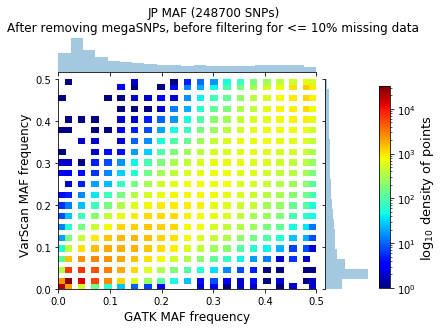

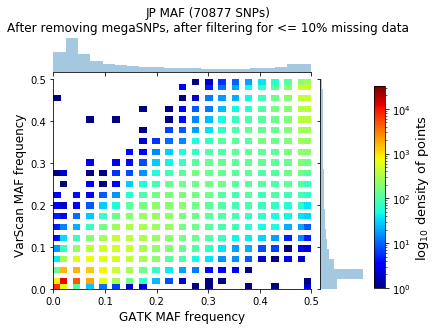

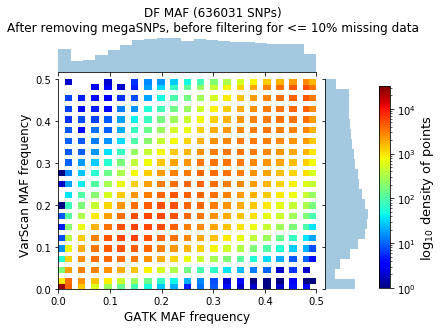

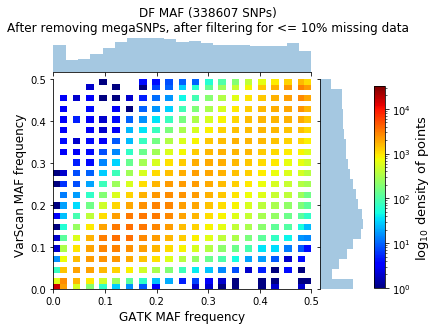

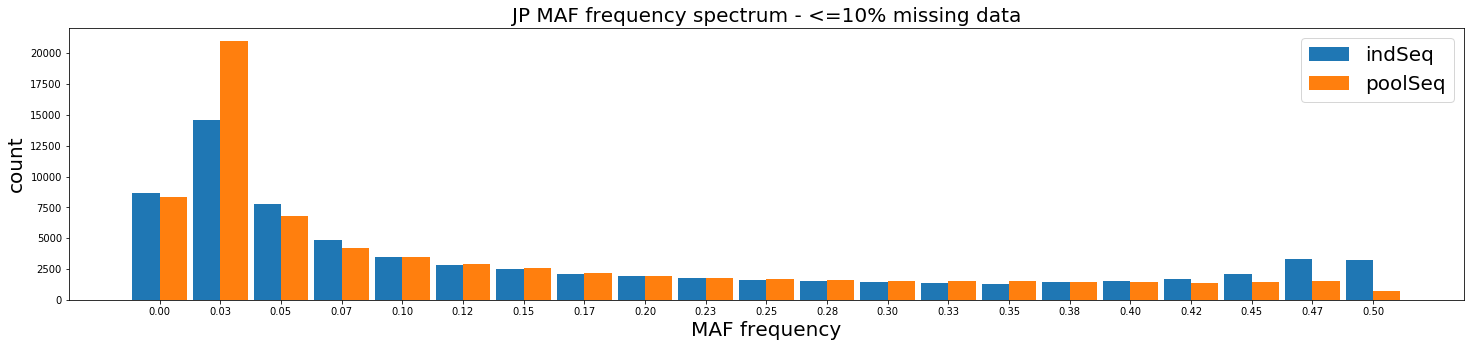

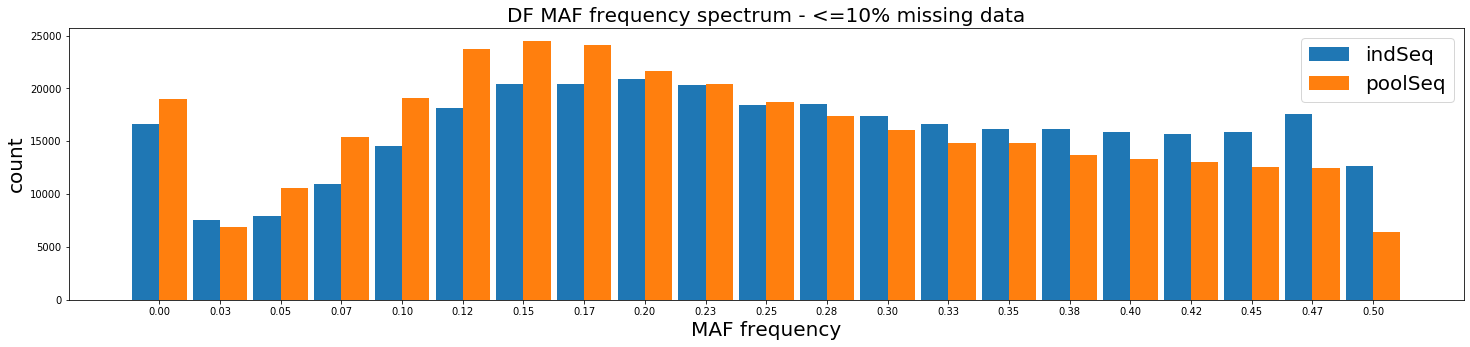

In [42]:
# filter for < 10% missing data (2/20 = 0.1)
after = filter_missing_data(newsnps, 2, ret=True)
compare_sweetgraphs(before=newsnps,
                    after=after,
                    doingwhat='filtering for <= 10% missing data')
# show species MAF spectra
for sp in ['JP', 'DF']:
    make_mafdict_fig(get_mafdict(after['gatk'][sp]['realMAF'], roundto=3),
                     get_mafdict(after['varscan'][sp]['realMAF'], roundto=3),
                     xlab = 'MAF frequency',
                     legend=['indSeq','poolSeq'], title=f'{sp} MAF frequency spectrum - <=10% missing data')

#### filter for all three

JP starting =  248700
JP ending =  213421
Correlation decreased :(
0.97756 0.97594 

DF starting =  636031
DF ending =  523927
Correlation decreased :(
0.94831 0.9449 

JP starting =  213421
JP ending =  153046
Correlation increased!!!
0.97594 0.9897 

DF starting =  523927
DF ending =  339797


 14%|█▍        | 21864/153046 [00:00<00:00, 209415.88it/s]

Correlation increased!!!
0.9449 0.97022 



100%|██████████| 153046/153046 [00:00<00:00, 185970.66it/s]


56


100%|██████████| 339797/339797 [00:01<00:00, 213309.70it/s]


56
JP starting =  153046
JP ending =  153046
Correlation increased!!!
0.9897 0.99071 

DF starting =  339797
DF ending =  339797
Correlation increased!!!
0.97022 0.97469 



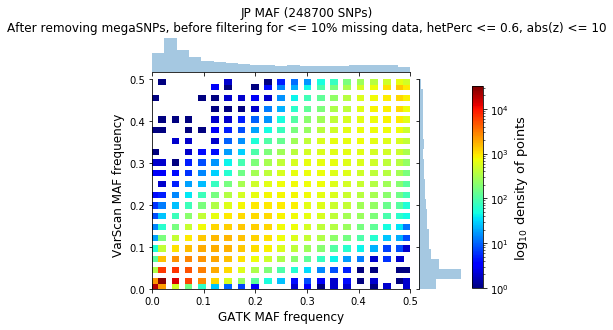

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/all-three-filtered_congurence_MAF_spectrum_JP.pdf


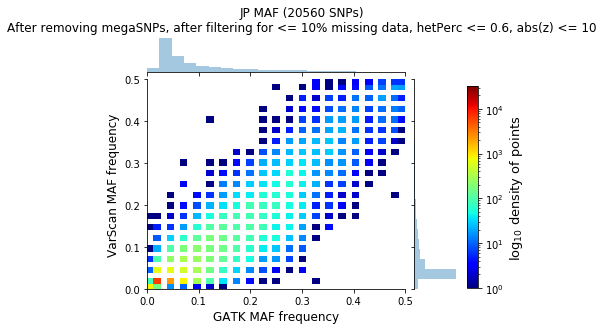

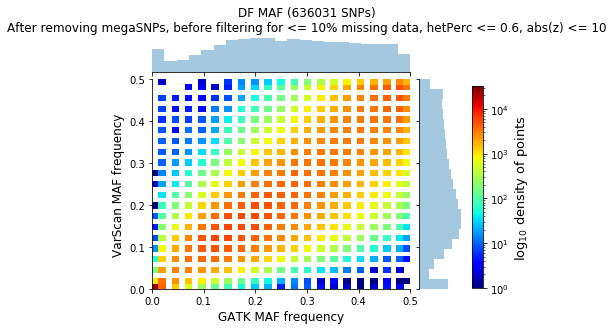

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/all-three-filtered_congurence_MAF_spectrum_DF.pdf


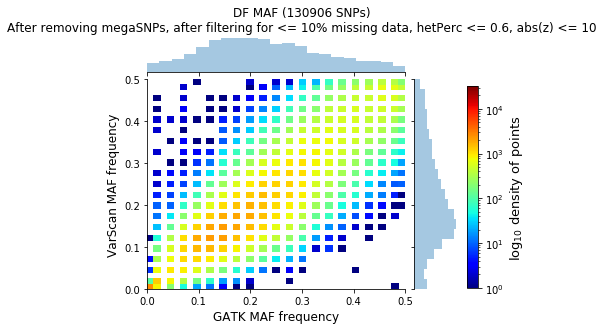

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/all-three-filtered_MAF-spectrum_JP.pdf


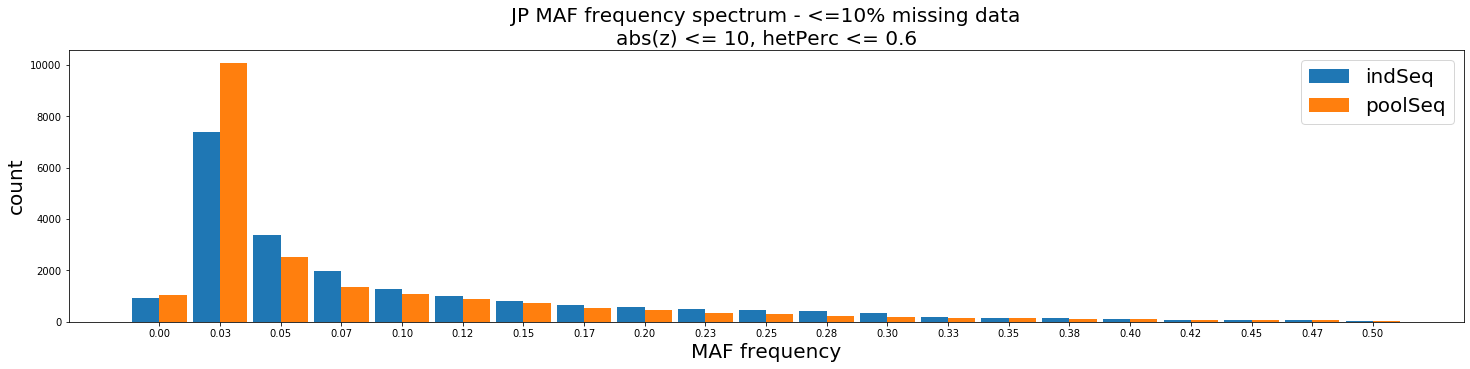

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/all-three-filtered_MAF-spectrum_DF.pdf


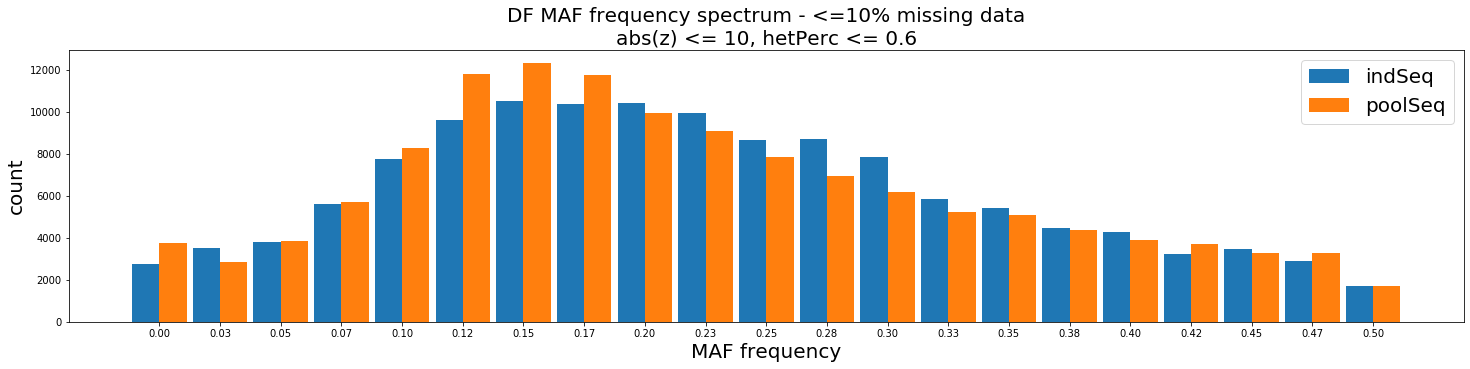

In [43]:
# correlation is great for less than 10% missing data + hetPerc filt + z-score filt
after = filter_missing_data(filter_snps(filter_snps(newsnps, col='abs(z)', greaterthan=False, byval=10),
                                       col='hetPerc', greaterthan=False, byval=0.6),
                           1, ret=True)
compare_sweetgraphs(before=newsnps,
                    after=after,
                    doingwhat='filtering for <= 10% missing data, hetPerc <= 0.6, abs(z) <= 10',
                    saveloc=op.join(figdir, 'all-three-filtered_congurence_MAF_spectrum.pdf'))
# show species MAF spectra
for sp in ['JP', 'DF']:
    make_mafdict_fig(get_mafdict(after['gatk'][sp]['realMAF'], roundto=3),
                     get_mafdict(after['varscan'][sp]['realMAF'], roundto=3),
                     xlab = 'MAF frequency',
                     legend=['indSeq','poolSeq'],
                     title=f'{sp} MAF frequency spectrum - <=10% missing data\nabs(z) <= 10, hetPerc <= 0.6',
                     saveloc=op.join(figdir, f'all-three-filtered_MAF-spectrum_{sp}.pdf'))

JP starting =  248700
JP ending =  213421
Correlation decreased :(
0.97756 0.97594 

DF starting =  636031
DF ending =  523927
Correlation decreased :(
0.94831 0.9449 

JP starting =  213421
JP ending =  153046
Correlation increased!!!
0.97594 0.9897 

DF starting =  523927
DF ending =  339797


  0%|          | 0/153046 [00:00<?, ?it/s]

Correlation increased!!!
0.9449 0.97022 



100%|██████████| 153046/153046 [00:00<00:00, 192452.78it/s]


56


100%|██████████| 339797/339797 [00:01<00:00, 183344.23it/s]


56
JP starting =  153046
JP ending =  153046
Correlation increased!!!
0.9897 0.99066 

DF starting =  339797
DF ending =  339797
Correlation increased!!!
0.97022 0.97322 



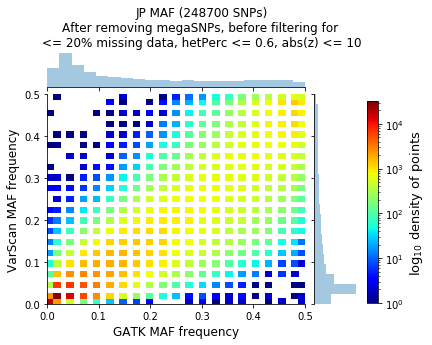

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/all-three-filtered_congurence_MAF_spectrum_20perc_JP.pdf


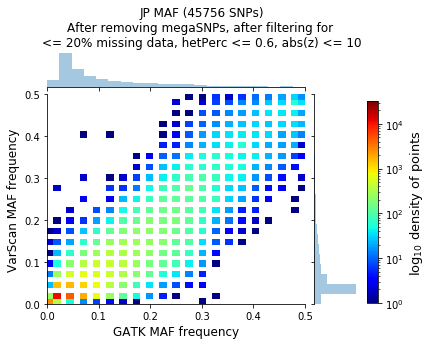

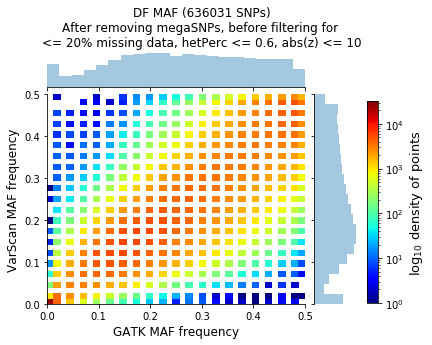

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/all-three-filtered_congurence_MAF_spectrum_20perc_DF.pdf


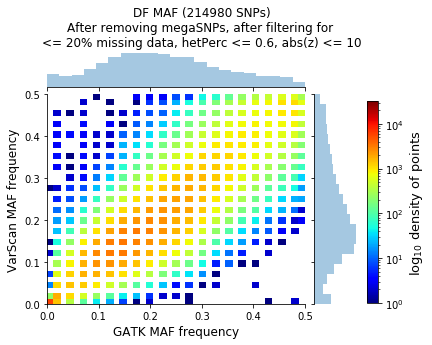

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/all-three-filtered_MAF-spectrum_JP_20perc.pdf


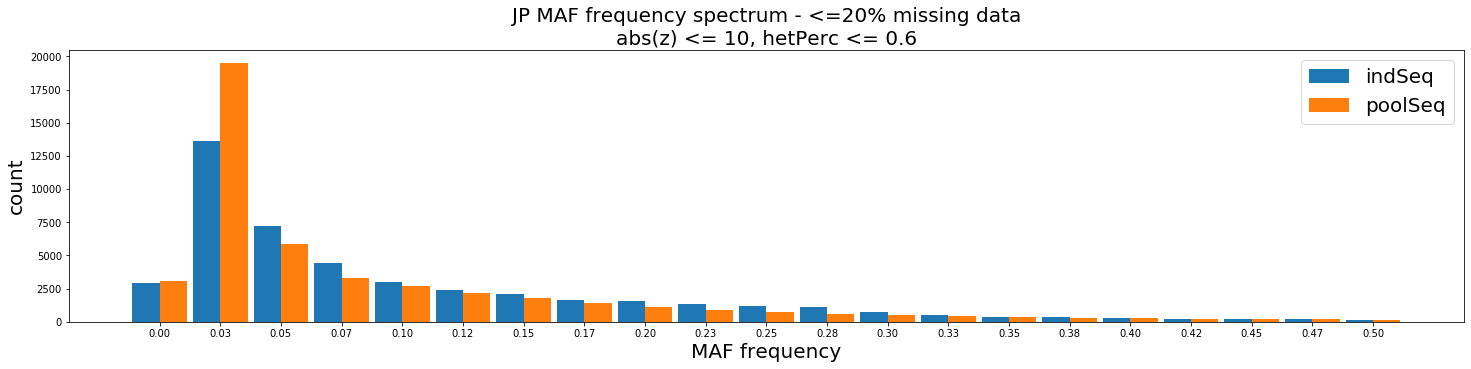

Saved to:  /data/home/lindb/methods_paper_analysis/002_testdata_compare_AFs/figures/all-three-filtered_MAF-spectrum_DF_20perc.pdf


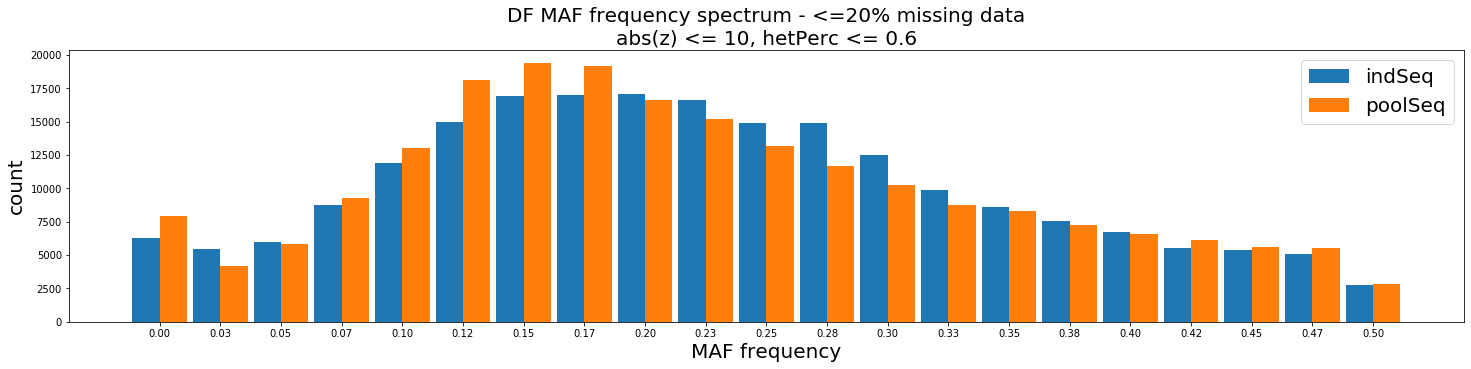

In [44]:
# correlation is slightly lower when looking at less than 20% missing data (as expected, less missing data is better)
after = filter_missing_data(filter_snps(filter_snps(newsnps, col='abs(z)', greaterthan=False, byval=10),
                                        col='hetPerc', greaterthan=False, byval=0.6),
                            2, ret=True)
compare_sweetgraphs(before=newsnps,
                    after=after,
                    doingwhat='filtering for \n<= 20% missing data, hetPerc <= 0.6, abs(z) <= 10',
                    saveloc=op.join(figdir, 'all-three-filtered_congurence_MAF_spectrum_20perc.pdf'))
# show species MAF spectra
for sp in ['JP', 'DF']:
    make_mafdict_fig(get_mafdict(after['gatk'][sp]['realMAF'], roundto=3),
                     get_mafdict(after['varscan'][sp]['realMAF'], roundto=3),
                     xlab = 'MAF frequency',
                     legend=['indSeq','poolSeq'],
                     title=f'{sp} MAF frequency spectrum - <=20% missing data\nabs(z) <= 10, hetPerc <= 0.6',
                     saveloc=op.join(figdir, f'all-three-filtered_MAF-spectrum_{sp}_20perc.pdf'))